In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


# Deep learning packages
from keras.models import Sequential
from keras.layers import LSTM, Dense

#enable IPython to display matplolib graphs
%matplotlib inline


2022-03-15 12:51:32.115965: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-15 12:51:32.115988: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from ML_classes.MLPModel import MLPModel


In [3]:
df = pd.read_csv('./data/ouput.csv')
df['tstp'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in df['tstp']]
#df["tstp"] = pd.to_datetime(df["tstp"])
df["energy(kWh/hh)"] = pd.to_numeric(df["energy(kWh/hh)"], downcast="float", errors="coerce")

max_value_energy = df["energy(kWh/hh)"].max()
df['energy(kWh/hh)'] = df['energy(kWh/hh)'].apply(lambda x: x / max_value_energy)
# Sorting the values
df.sort_values('tstp', inplace=True)

In [4]:
lclid_list = df['LCLid'].unique()
def find_household(identification):
    affluenthh_filt = df["LCLid"] == identification
    affluent_hh_data = df[affluenthh_filt]
    return affluent_hh_data

hh = find_household("MAC000150")
hh.pop("LCLid")
hh = hh.set_index("tstp")
hh = hh.resample("H").sum()
hh = hh.reset_index()

In [5]:
# Initiating the class
deep_learner = MLPModel(
data = hh,
Y_var = 'energy(kWh/hh)',
lag = 24,
layer_depth = 50,
epochs = 40,
batch_size = 256,
train_test_split = 0.15
)

In [6]:
# Fitting the model

model = deep_learner.MLPModel()

Epoch 1/40


2022-03-15 12:51:35.627870: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-15 12:51:35.628154: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-15 12:51:35.628185: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-15 12:51:35.628209: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-15 12:51:35.628232: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

66/66 [==============================] - 0s 2ms/step - loss: 0.0088 - val_loss: 0.0058
Epoch 2/40
66/66 [==============================] - 0s 1ms/step - loss: 0.0053 - val_loss: 0.0051
Epoch 3/40
66/66 [==============================] - 0s 1ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 4/40
66/66 [==============================] - 0s 1ms/step - loss: 0.0050 - val_loss: 0.0049
Epoch 5/40
66/66 [==============================] - 0s 1ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 6/40
66/66 [==============================] - 0s 991us/step - loss: 0.0049 - val_loss: 0.0049
Epoch 7/40
66/66 [==============================] - 0s 1ms/step - loss: 0.0048 - val_loss: 0.0049
Epoch 8/40
66/66 [==============================] - 0s 1ms/step - loss: 0.0048 - val_loss: 0.0049
Epoch 9/40
66/66 [==============================] - 0s 995us/step - loss: 0.0048 - val_loss: 0.0049
Epoch 10/40
66/66 [==============================] - 0s 995us/step - loss: 0.0048 - val_loss: 0.0049
Epoch 11/40
66/66 [=====

In [7]:
deep_learner.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                1250      
                                                                 
 dense_1 (Dense)             (None, 25)                1275      
                                                                 
 dense_2 (Dense)             (None, 1)                 26        
                                                                 
Total params: 2,551
Trainable params: 2,551
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Defining the lag that we used for training of the model 
lag_model = 24
# Getting the last period
ts = hh['energy(kWh/hh)'].tail(lag_model).values.tolist()
# Creating the X matrix for the model
X, _ = deep_learner.dc.create_X_Y(ts, lag=lag_model)
# Getting the forecast
yhat = model.predict(X)

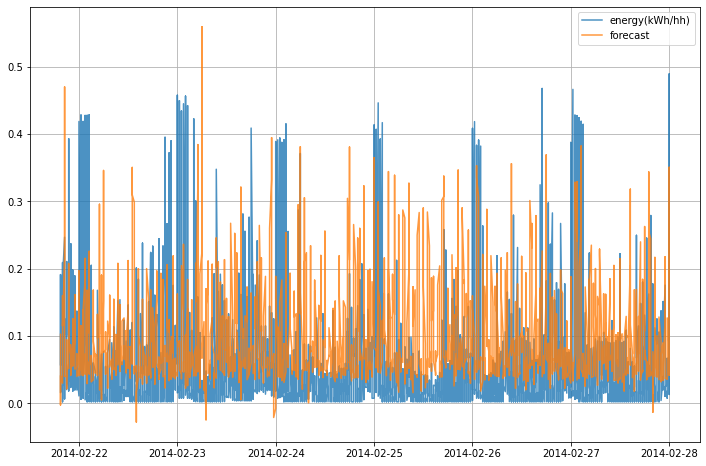

In [9]:
yhat = deep_learner.predict()
# Constructing the forecast dataframe
fc = df.tail(len(yhat)).copy()
fc.reset_index(inplace=True)
fc['forecast'] = yhat
# Ploting the forecasts
plt.figure(figsize=(12, 8))
for dtype in ['energy(kWh/hh)', 'forecast']:
  plt.plot(
    'tstp',
    dtype,
    data=fc,
    label=dtype,
    alpha=0.8
  )
plt.legend()
plt.grid()

/tmp/ipykernel_296600/2528746469.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc = fc.append(hat_frame)


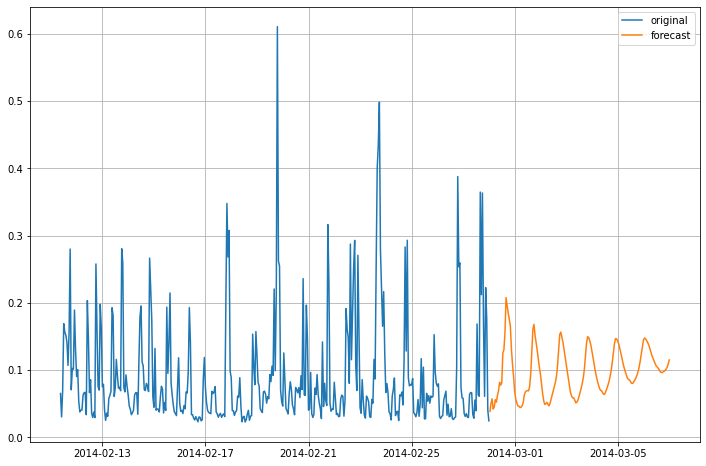

In [10]:

#Forecasting n steps ahead
n_ahead = 168
yhat = deep_learner.predict_n_ahead(n_ahead)
yhat = [y[0][0] for y in yhat]

#Constructing the forecast dataframe
fc = hh.tail(400).copy() 
fc['type'] = 'original'

last_date = max(fc['tstp'])
hat_frame = pd.DataFrame({
    'tstp': [last_date + timedelta(hours=x + 1) for x in range(n_ahead)], 
    'energy(kWh/hh)': yhat,
    'type': 'forecast'
})

fc = fc.append(hat_frame)
fc.reset_index(inplace=True, drop=True)
#Ploting the forecasts 
plt.figure(figsize=(12, 8))
for col_type in ['original', 'forecast']:
    plt.plot(
        'tstp', 
        'energy(kWh/hh)', 
        data=fc[fc['type']==col_type],
        label=col_type
        )

plt.legend()
plt.grid()   

In [11]:
deep_learner.evaluateMSE()

0.0050126988205170505

In [12]:
deep_learner.evaluateRMSE()

0.0708004153979131

In [13]:
deep_learner.evaluateMAE()

0.042499063389469974

In [14]:
deep_learner.evaluateMAPE()

47.54296395909041

In [15]:
yhat =deep_learner.predict()

In [16]:
yhat

[0.10251914,
 0.06918665,
 0.09194081,
 0.018652089,
 -0.002333655,
 0.041350964,
 0.030028991,
 0.07182506,
 0.088421576,
 0.1600278,
 0.051210884,
 0.102101825,
 0.079366475,
 0.031398926,
 0.12135233,
 0.11502499,
 0.21451384,
 0.390486,
 0.47002652,
 0.29460517,
 0.1728308,
 0.1985069,
 0.16684295,
 0.106108874,
 0.050919134,
 0.04000709,
 0.040144715,
 0.07270428,
 0.06064168,
 0.07282918,
 0.037588697,
 0.07151596,
 0.021655846,
 0.09441132,
 0.07558943,
 0.056720484,
 0.051572867,
 0.13013932,
 0.20774683,
 0.14710456,
 0.0618721,
 0.13181104,
 0.11795366,
 0.11100052,
 0.11112272,
 0.094135284,
 0.07161713,
 0.060066056,
 0.045574695,
 0.04754699,
 0.049042642,
 0.047131605,
 0.042943906,
 0.04192865,
 0.076950505,
 0.08728538,
 0.055972245,
 0.058322117,
 0.05583741,
 0.08651962,
 0.12571773,
 0.0856954,
 0.079789154,
 0.06448605,
 0.101667546,
 0.06687603,
 0.09255439,
 0.11196852,
 0.06943183,
 0.09143469,
 0.16149424,
 0.09264158,
 0.099095024,
 0.07362233,
 0.0586632,
 0.0